https://chatgpt.com/share/68703dc5-4ff0-8008-9153-42348685b941

In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [2]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [3]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [4]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(1)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [5]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(r'(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$', ws_name)
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {'model', 'lang_pair'}.issubset(df.columns):
                continue
            # Budget Column
            budget_cols = [col for col in df.columns if isinstance(col, (int, float)) or (isinstance(col, str) and col.isdigit())]
            budget_cols = sorted(budget_cols, key=lambda x: int(x))
            for _, row in df.iterrows():
                model = row['model']
                lang_pair = row['lang_pair']
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    dfs_by_metric[metric].append({
                        'model': model,
                        'task': task,
                        'metric': metric,
                        'lang_pair': lang_pair,
                        'budget': int(budget),
                        'score': float(val)
                    })

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric

dfs_by_metric = split_by_metric(all_data)

In [6]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [7]:
dfs_by_metric['comet_kiwi_score']

,model,task,metric,lang_pair,budget,score
0,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,0,0.694328
1,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,100,0.694022
2,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,200,0.694338
3,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,300,0.693046
4,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_kiwi_score,Avg,400,0.692750
...,...,...,...,...,...,...
2827,Qwen3-8B,WMT23-Biomedical-Sentence,comet_kiwi_score,ru-en,300,0.725409
2828,Qwen3-8B,WMT23-Biomedical-Sentence,comet_kiwi_score,ru-en,400,0.719083
2829,Qwen3-8B,WMT23-Biomedical-Sentence,comet_kiwi_score,ru-en,500,0.727374
2830,Qwen3-8B,WMT23-Biomedical-Sentence,comet_kiwi_score,ru-en,1000,0.723582


In [8]:
def plot_model_scores(
    df, 
    task, 
    lang_pair, 
    models,
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(7,5)
):
    plot_df = df[
        (df['task'] == task) &
        (df['lang_pair'] == lang_pair) &
        (df['model'].isin(models))
    ]
    if plot_df.empty:
        print('No data found for the given criteria. Please check')
        return
    
    plt.figure(figsize=figsize)
    for model in models:
        sub = plot_df[plot_df['model'] == model]
        sub = sub.sort_values('budget')
        plt.plot(sub['budget'], sub['score'], marker='o', label=model)
    plt.xlabel('Budget')
    plt.ylabel('Score')
    plt.title(f'{task} | {lang_pair}')
    plt.xticks(budget_ticks)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
# plot_model_scores(
#     dfs_by_metric['comet_kiwi_score'],
#     task='WMT23-Biomedical-Sentence',
#     lang_pair='Avg',
#     # models=['Qwen3-0.6B', 'Qwen3-1.7B']
#     # models=['Qwen3-4B', 'Qwen3-8B']
#     # models=['Qwen3-14B', 'Qwen3-32B']
# )

In [10]:
def plot_models_groups_side_by_side(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(16,5)
):
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]
    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df['task'] == task) &
            (df['metric'] == metric) &
            (df['lang_pair'] == lang_pair) &
            (df['model'].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue
        for model in models:
            sub = group_df[group_df['model'] == model].sort_values('budget')
            ax.plot(sub['budget'], sub['score'], marker='o', label=model)
        ax.set_xlabel('Budget')
        ax.set_xticks(budget_ticks)
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel('Score')
        ax.legend(loc='lower right', framealpha=0.25)
    plt.suptitle(f'{task} | {metric} | {lang_pair}')
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()


### Biomedical Translation

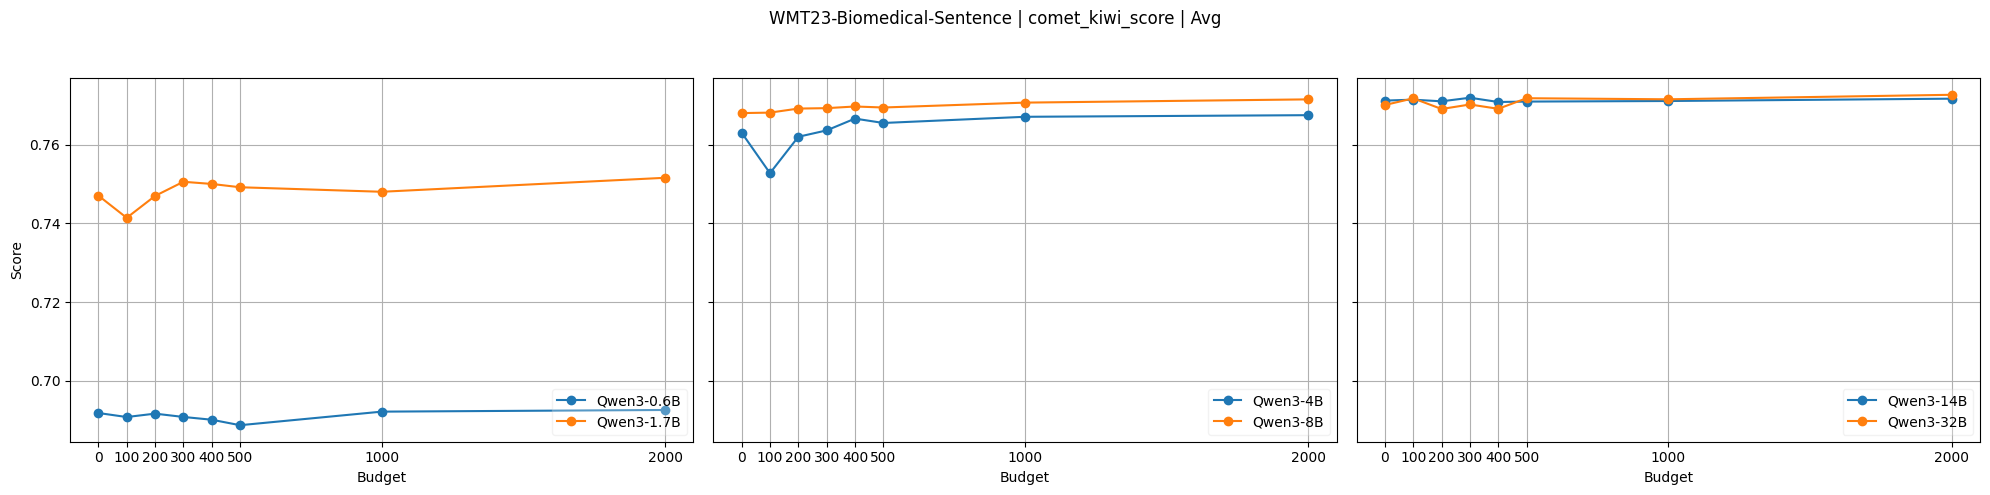

In [11]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT23-Biomedical-Sentence',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

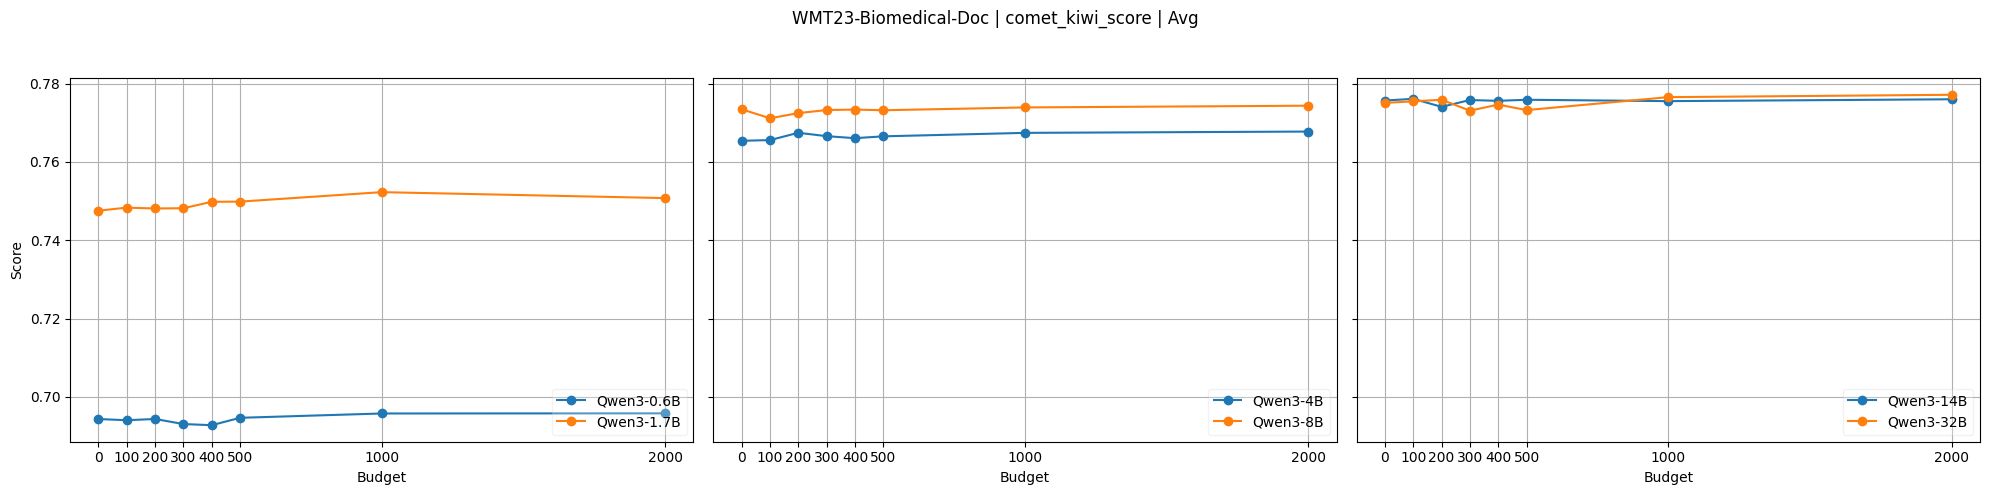

In [12]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT23-Biomedical-Doc',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

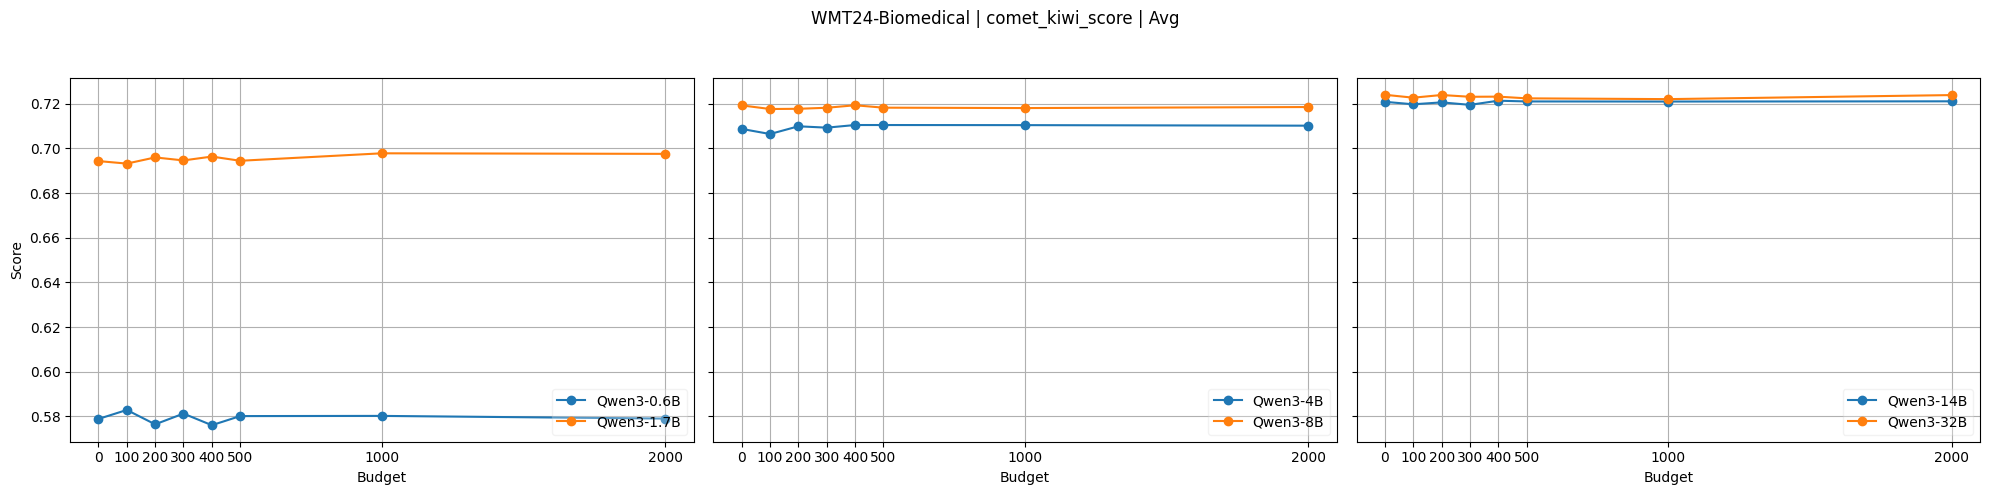

In [13]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT24-Biomedical',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

### Terminminology Translation

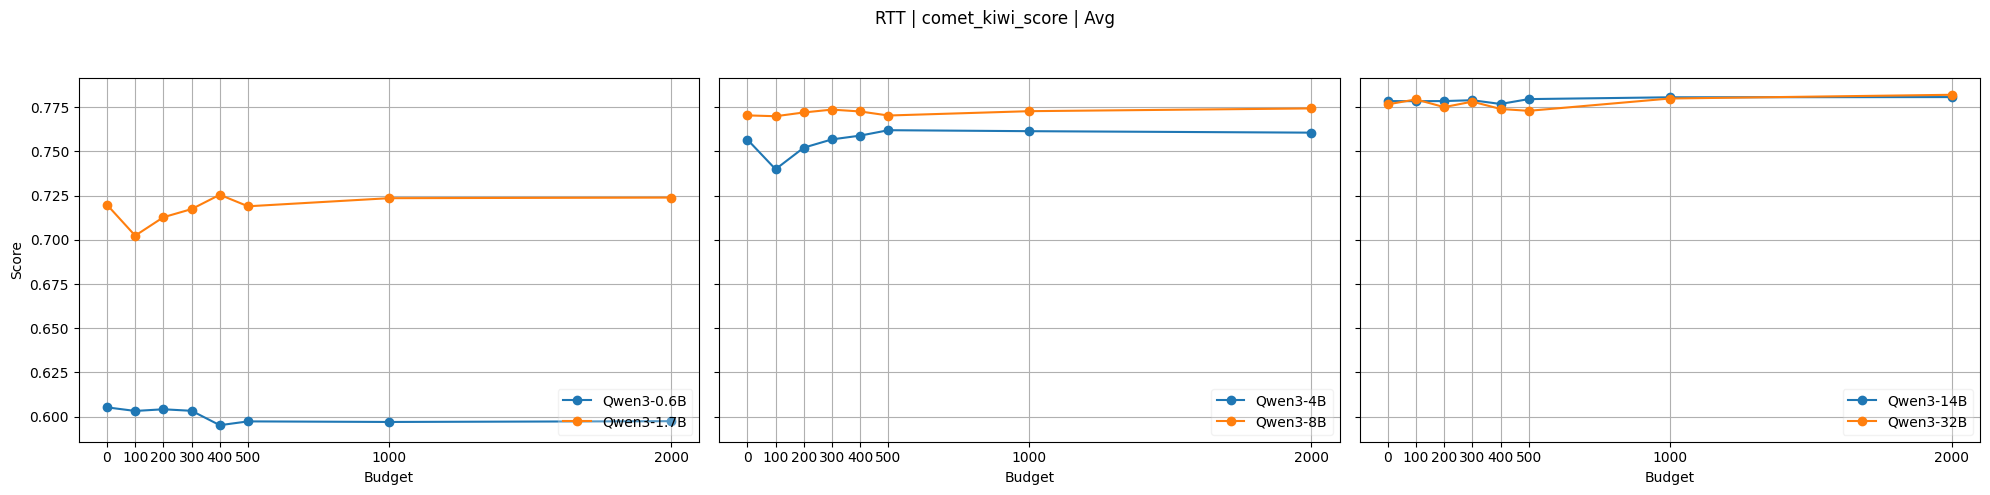

In [14]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='RTT',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

### Commosence Translation

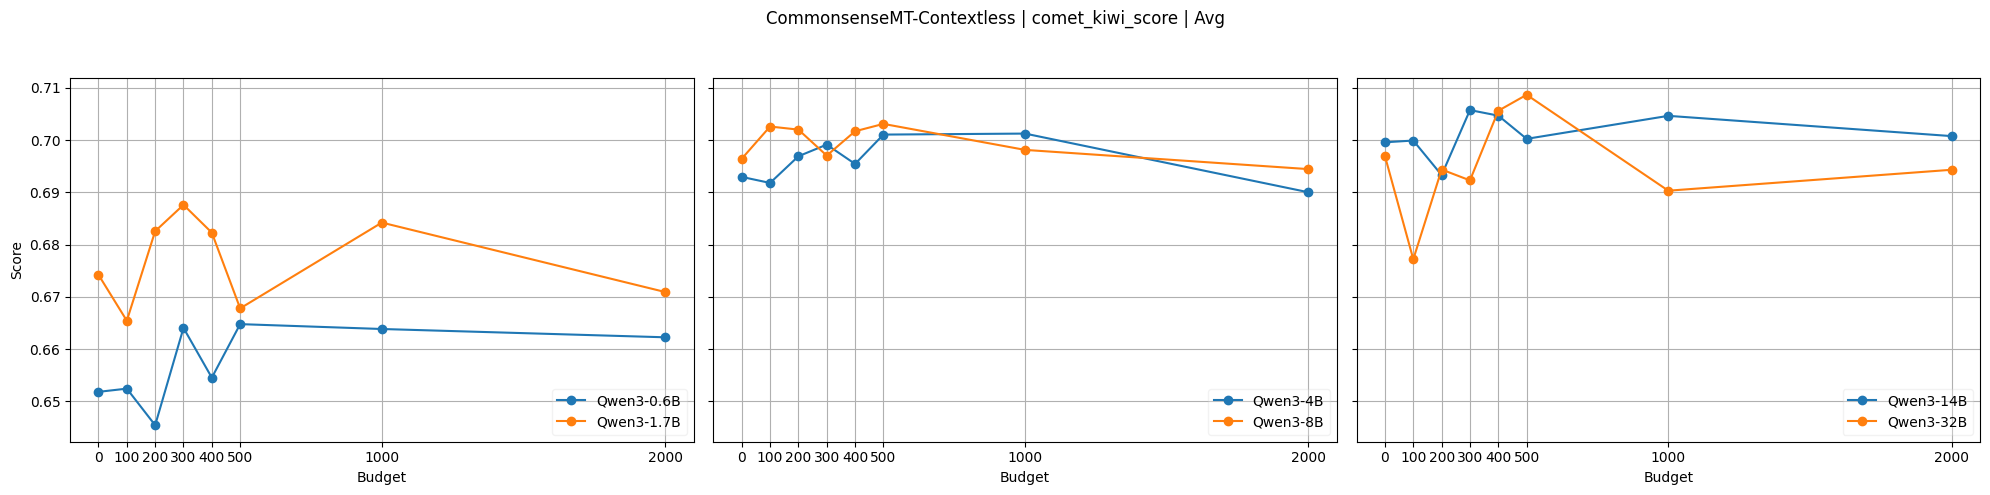

In [15]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Contextless',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

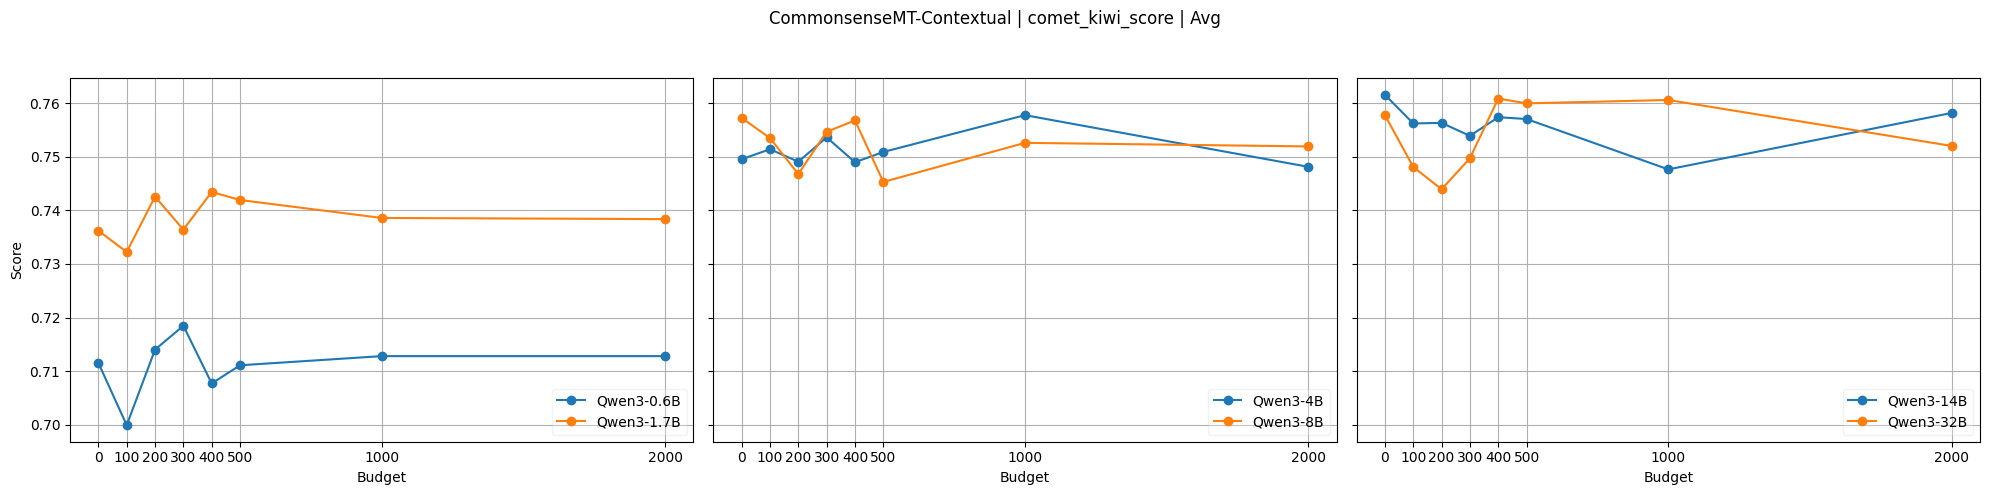

In [16]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Contextual',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

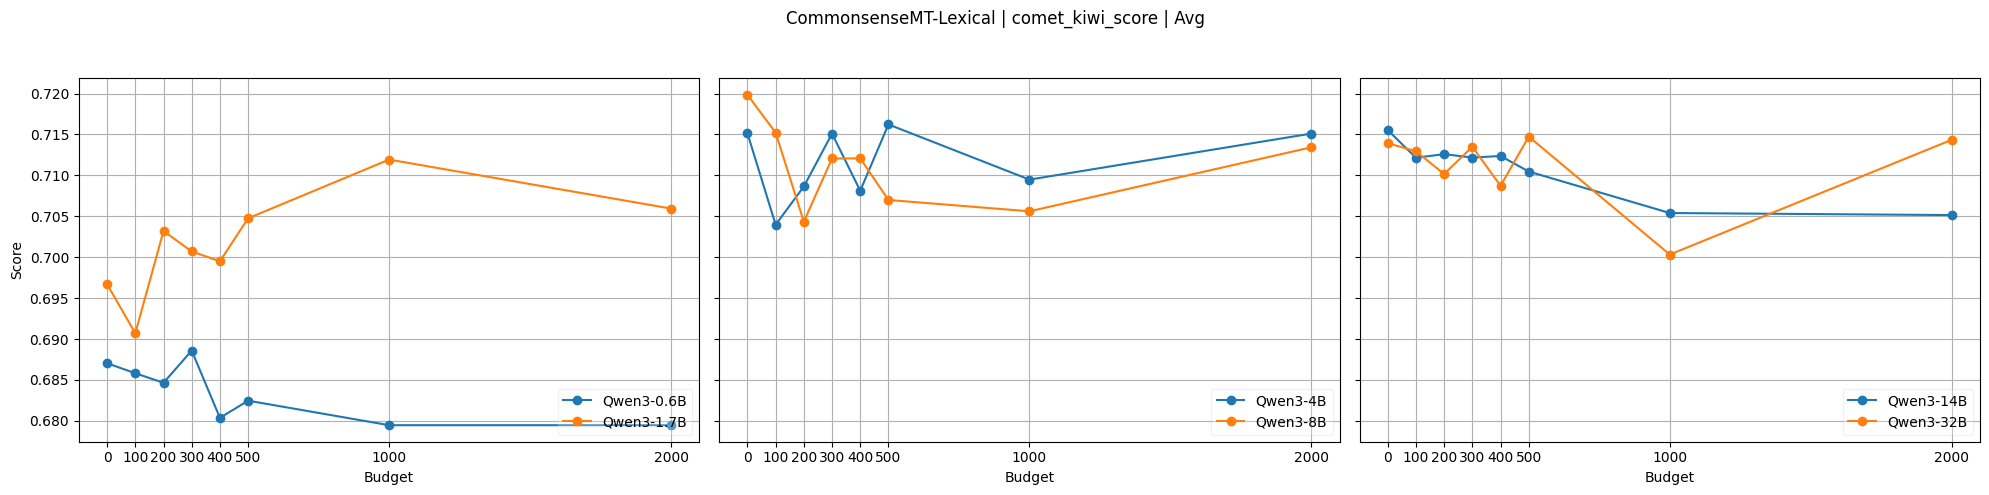

In [17]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='CommonsenseMT-Lexical',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

### Literterature Transaltion

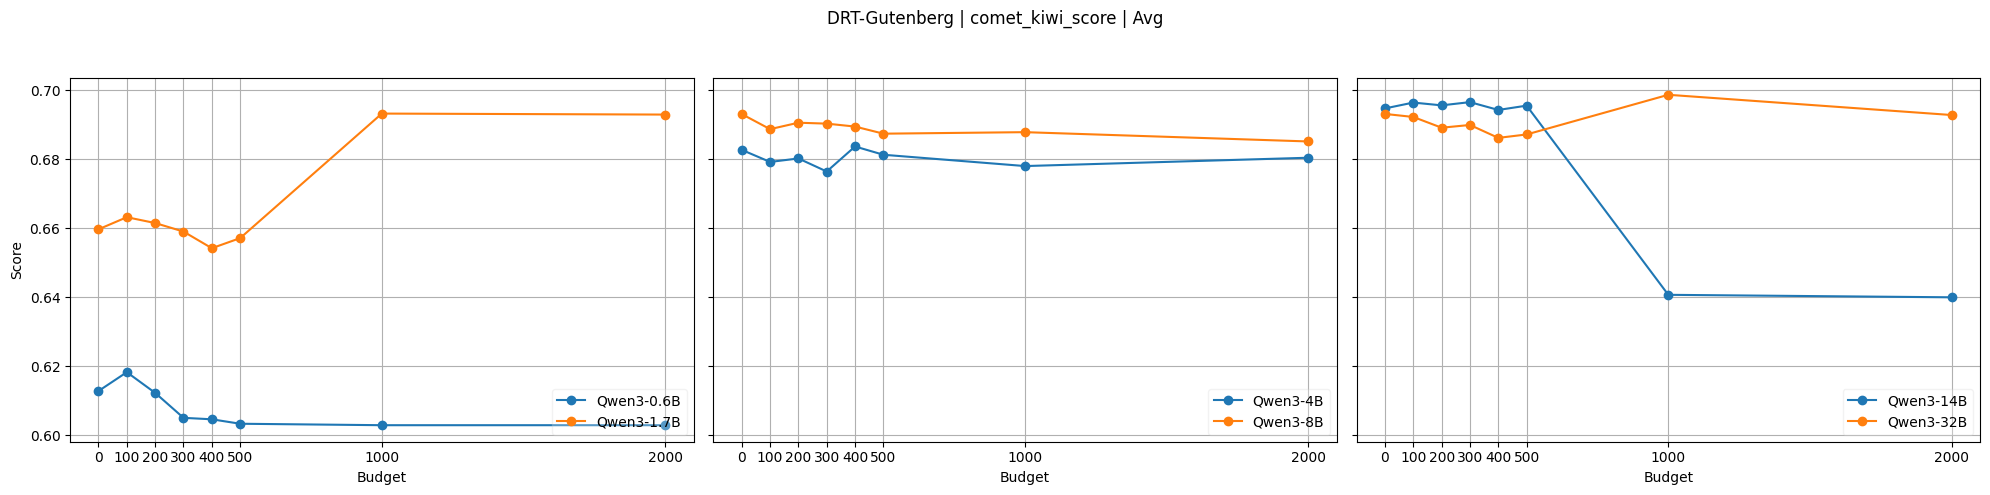

In [18]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='DRT-Gutenberg',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

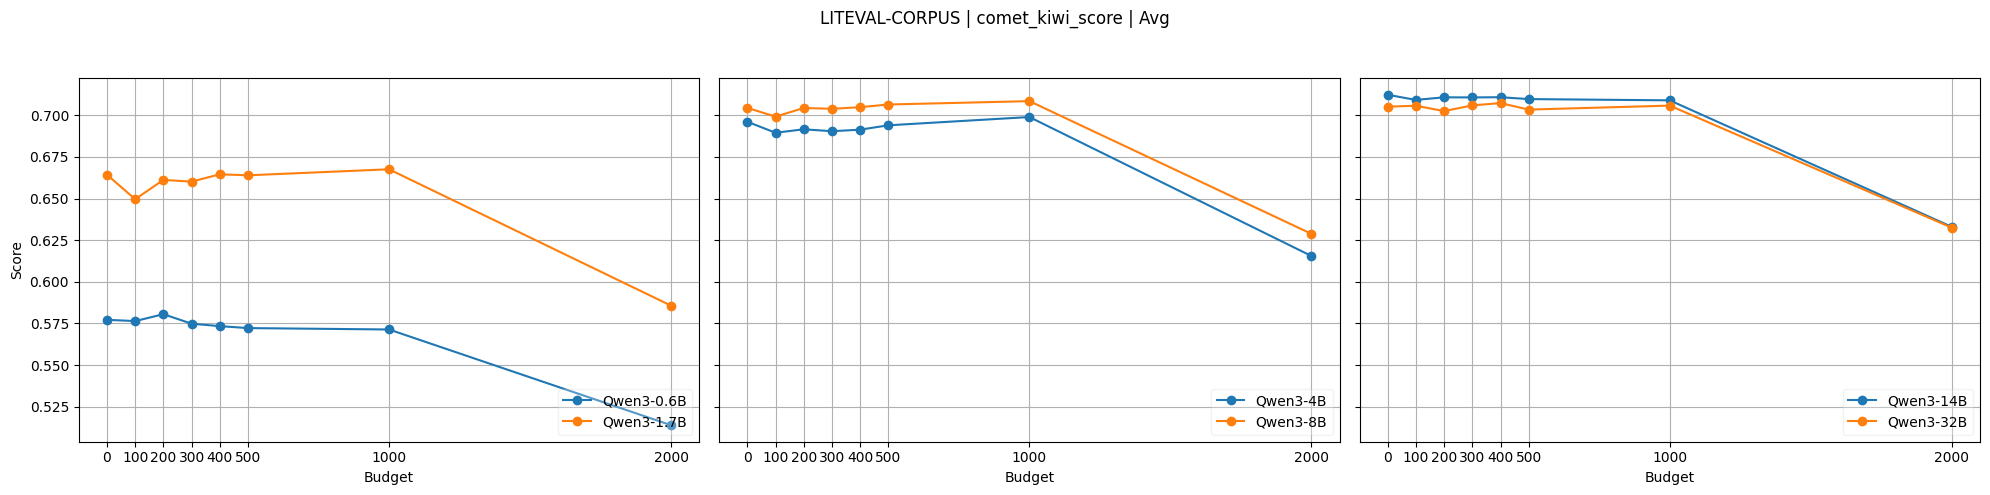

In [19]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='LITEVAL-CORPUS',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)

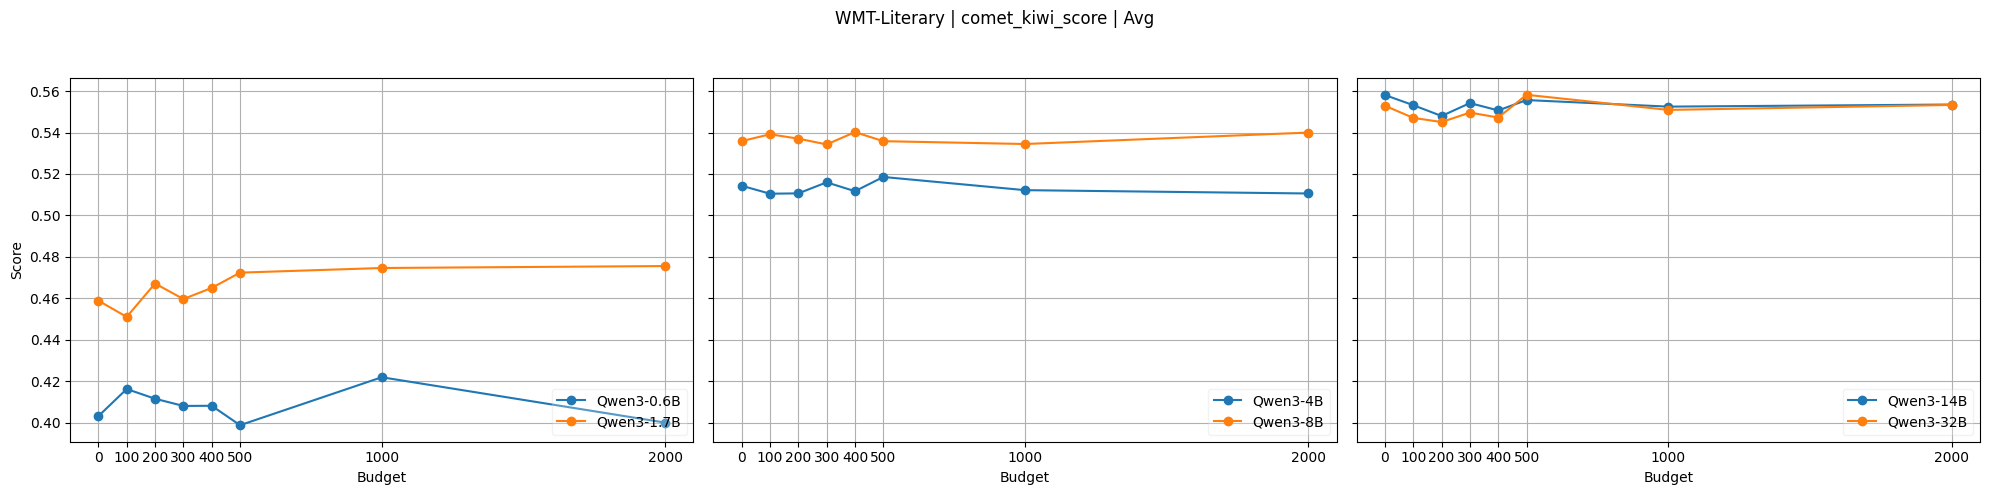

In [20]:
plot_models_groups_side_by_side(
    dfs_by_metric['comet_kiwi_score'],
    task='WMT-Literary',
    metric='comet_kiwi_score',
    lang_pair='Avg',
    model_groups=[
        ['Qwen3-0.6B', 'Qwen3-1.7B'],
        ['Qwen3-4B', 'Qwen3-8B'],
        ['Qwen3-14B', 'Qwen3-32B'],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5)
)